In [1]:
# Imports

import argparse
import json
import logging
import os
import random
import sys
from dataclasses import dataclass
from typing import Tuple
from multiprocessing import Pool

import numpy as np
import pandas as pd
import torch
from torch import Tensor

from reagent.ope.estimators.estimator import Estimator, EstimatorResult
from reagent.ope.estimators.contextual_bandits_estimators import (
    Action,
    ActionDistribution,
    ActionRewards,
    BanditsEstimatorInput,
    BanditsModel,
    DMEstimator,
    DoublyRobustEstimator,
    IPSEstimator,
    LogSample,
    SwitchEstimator,
    SwitchDREstimator
)
from reagent.ope.estimators.types import ActionSpace, Policy, Trainer
from reagent.ope.trainers.linear_trainers import (
    LogisticRegressionTrainer,
    SGDClassifierTrainer,
    TrainingData,
    DecisionTreeTrainer,
    LinearTrainer
)
from reagent.ope.test.multiclass_bandits import (
    MultiClassDataRow,
    UCIMultiClassDataset,
    MultiClassContext,
    MultiClassModel,
    MultiClassPolicy,
    evaluate_all
)
from reagent.ope.utils import RunningAverage, Clamper

import matplotlib
import matplotlib.pyplot as plt

/home/alexschneidman/anaconda3/envs/ope/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alexschneidman/anaconda3/envs/ope/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alexschneidman/anaconda3/envs/ope/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alex

## Configuration Settings

Edit the experiments list with the names of UCI datasets given in reagent/test/data to produce results for each dataset. 

In [2]:
# Configuration

DEFAULT_ITERATIONS = 500
TEST_ROOT_PATH = '..'
UCI_DATASET_CONFIGS = os.path.join(TEST_ROOT_PATH, 'configs')
MAX_METRIC_NAME_LENGTH = 20
experiments = ["ecoli", "letter_recog", "pendigits", "optdigits", "satimage"]

experiment_params = []
for exp in experiments:
    with open(os.path.join(UCI_DATASET_CONFIGS, exp + '_config.json'), "r") as f:
        params = json.load(f)
        if "dataset" in params:
            if "file" in params["dataset"]:
                params["dataset"]["file"] = os.path.join(TEST_ROOT_PATH, params["dataset"]["file"])
        experiment_params.append({"name": exp, "params": params})     

## Run an experiment

We load the given dataset, and create trainers (which will be used for generating the policies for the logger and target). To try different trainers, modify the `log_trainer` and `tgt_trainer` variables with different `LinearTrainer`s. 

Note that DM's performance is highly dependent on the reward model. To try different reward models, modify the trainer passed into `DMEstimator` and `DoublyRobustEstimator` with different `LinearTrainer`s. 

In [3]:
def load_dataset(params):
        return UCIMultiClassDataset(params["dataset"])

In [4]:
# Experiment(s)
def run_experiment(dataset): 
    random.seed(1234)
    np.random.seed(1234)
    torch.random.manual_seed(1234)

    log_trainer = LogisticRegressionTrainer()
    log_epsilon = 0.1
    tgt_trainer = SGDClassifierTrainer()
    tgt_epsilon = 0.1
    experiments = [
        (
            (
                SwitchEstimator(LogisticRegressionTrainer(), rmax=1.0),
                SwitchDREstimator(LogisticRegressionTrainer(), rmax=1.0),
                DMEstimator(LogisticRegressionTrainer()),
                IPSEstimator(),
                DoublyRobustEstimator(LogisticRegressionTrainer()),
            ),
            1000,
        )
        for _ in range(3)
    ]
    results = evaluate_all(
        experiments, dataset, log_trainer, log_epsilon, tgt_trainer, tgt_epsilon, 0
    )
    return results


## Result Generation

For each UCI dataset, we generate a logging and target policy, create a simulated dataset using the logging policy, and evaluate the target policy using DM, IPS, and DR. The bias, rmse, and variance against the ground truth is plotted for each dataset. 


For the settings with the logging policy trained with a `LogisticRegressionTrainer`, the target policy with a `SGDClassifierTrainer`, and the reward model for DM and DR trained with a `LogisticRegressionTrainer`, a sample result gives:


![alt text](img/bias.png "Bias")![alt text](img/variance.png "Bias")![alt text](img/rmse.png "Bias")

In [5]:
datasets = []
for params in experiment_params:
    datasets.append(load_dataset(params['params']))
    
labels = []

bias_result_mapping = {}
var_result_mapping = {}
rmse_result_mapping = {}

In [6]:
for dataset, params in zip(datasets, experiment_params):
    print("Running experiment " + params["name"])
    if params["name"] in labels:
        continue
    exp_results = run_experiment(dataset)
    labels.append(params["name"])

    for estimator_name, result in exp_results.items():
        _, _, _, tgt_gt, _, _ = result.report()
        if not estimator_name in bias_result_mapping:
            bias_result_mapping[estimator_name] = []
        if not estimator_name in var_result_mapping:
            var_result_mapping[estimator_name] = []
        if not estimator_name in rmse_result_mapping:
            rmse_result_mapping[estimator_name] = []

        bias_result_mapping[estimator_name].append(tgt_gt.bias.cpu().numpy())
        var_result_mapping[estimator_name].append(tgt_gt.variance.cpu().numpy())
        rmse_result_mapping[estimator_name].append(tgt_gt.rmse.cpu().numpy())



Running experiment ecoli
SwitchEstimator(trainer(logistic_regression),weight_clamper(Clamper(-inf,inf)),device(None)) rewards: log_reward0.645333333333333 tgt_reward[0.6812217632929484] gt_reward[0.678666666666666], diffs: tgt-gt[samples=3, rmse=0.009468476910121438, bias=0.0025550966262824306, variance=0.00012468530434179442] tgt-log[samples=3, rmse=0.03596459723378409, bias=0.03588842995961542, variance=8.209273833132954e-06]
SwitchDREstimator(trainer(logistic_regression),weight_clamper(Clamper(-inf,inf)),device(None)) rewards: log_reward0.645333333333333 tgt_reward[0.6856557031472524] gt_reward[0.678666666666666], diffs: tgt-gt[samples=3, rmse=0.014910565329599071, bias=0.006989036480586426, variance=0.00026021749128191096] tgt-log[samples=3, rmse=0.04053359126783369, bias=0.04032236981391942, variance=2.561777048598451e-05]
DMEstimator(trainer(logistic_regression,device(None)) rewards: log_reward0.645333333333333 tgt_reward[0.6289458148905903] gt_reward[0.678666666666666], diffs: t

SwitchDREstimator(trainer(logistic_regression),weight_clamper(Clamper(-inf,inf)),device(None)) rewards: log_reward0.6753333333333339 tgt_reward[0.7257858514785767] gt_reward[0.7056666666666667], diffs: tgt-gt[samples=3, rmse=0.02325164297066486, bias=0.020119184811909923, variance=0.00020378595500922264] tgt-log[samples=3, rmse=0.05131790377001326, bias=0.0504525181452428, variance=0.00013210599022843076]
DMEstimator(trainer(logistic_regression,device(None)) rewards: log_reward0.6753333333333339 tgt_reward[0.6778973691215405] gt_reward[0.7056666666666667], diffs: tgt-gt[samples=3, rmse=0.02943021446549886, bias=-0.027769297545126175, variance=0.00014250545600326197] tgt-log[samples=3, rmse=0.003827464430881087, bias=0.0025640357882067053, variance=1.2112806669682652e-05]
IPSEstimator(weight_clamper(Clamper(-inf,inf)),weighted(False),device(None)) rewards: log_reward0.6753333333333339 tgt_reward[0.708646083625934] gt_reward[0.7056666666666667], diffs: tgt-gt[samples=3, rmse=0.0104327371

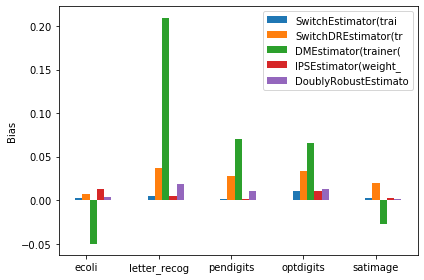

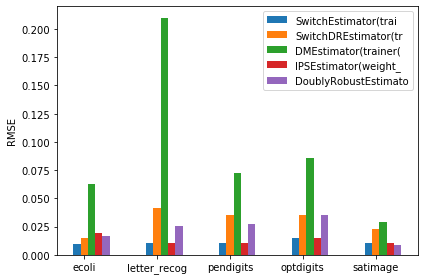

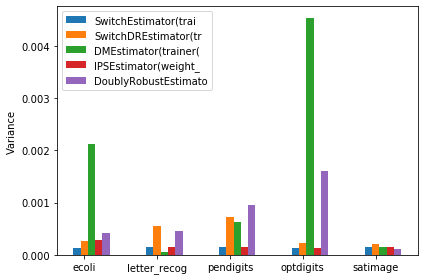

In [7]:
# Generate Bar Charts, a la https://arxiv.org/pdf/1511.03722.pdf

def create_and_show_chart(labels, results, title):
    # Width of each bar
    width = 0.1

    metrics = list(results.keys())
    
    # Set position of bar on X axis
    barpos = [np.arange(len(results[metrics[0]]))]
    for m in range(len(metrics)-1):
        barpos.append([x + width for x in barpos[-1]])
        
    fig, ax = plt.subplots()
    for metric, barpositions in zip(metrics, barpos):
        ax.bar(barpositions, results[metric], width, label=metric[:MAX_METRIC_NAME_LENGTH])

    ax.set_ylabel(title)
    plt.xticks([r + width for r in range(len(labels))], labels)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

create_and_show_chart(labels, bias_result_mapping, 'Bias')
create_and_show_chart(labels, rmse_result_mapping, 'RMSE')
create_and_show_chart(labels, var_result_mapping, 'Variance')